In [3]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle

# Get project's root directory
BASE_PATH = re.search(r'.+(Team5)', os.getcwd())[0]
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = './data'

## Task 1

In [4]:
"""
# TASK 1: Compute image descriptors (QS1)

Color Histogram:
    - gray level / concatenate color component histograms
    - color space RGB, CieLab, YCbCr, HSV.
    - Compulsory to use 1D histograms!
"""

from src.image_dataset import ImageDataset, ColorSpace
from src.image import ColorSpace, Image

In [6]:
# Load the DataBase and the Query 1
#BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', colorspace=ColorSpace.HSV, interval=1)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', colorspace=ColorSpace.HSV, interval=1)
QueryDataset.change_colorspace(new_colorspace=ColorSpace.CieLab)

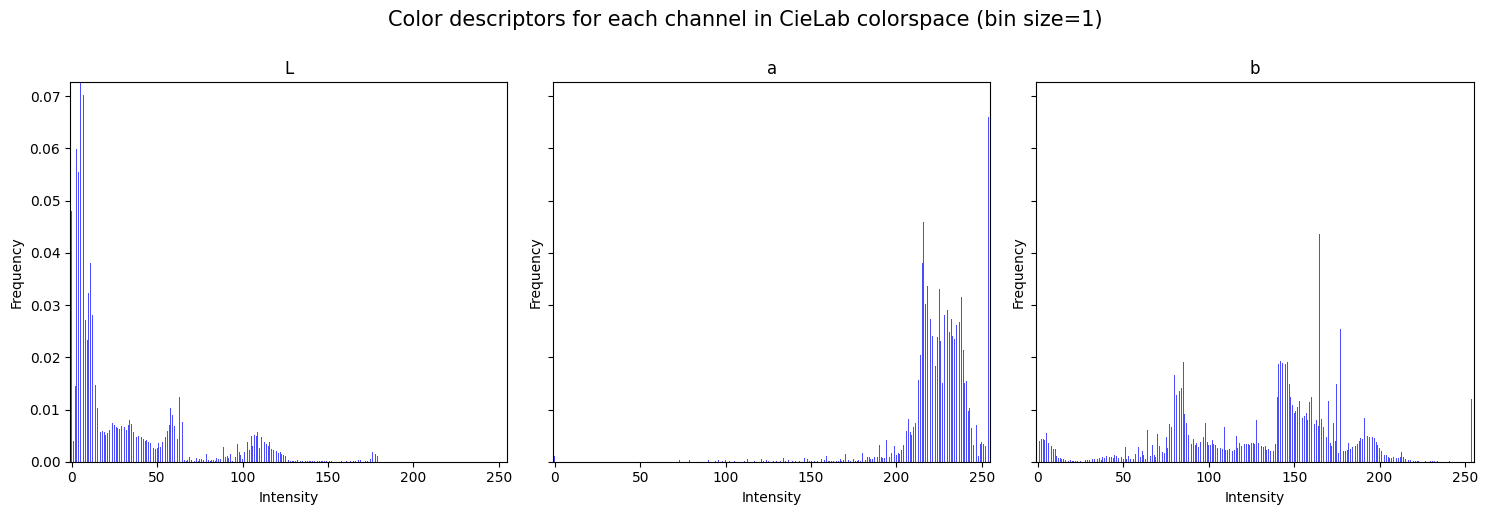

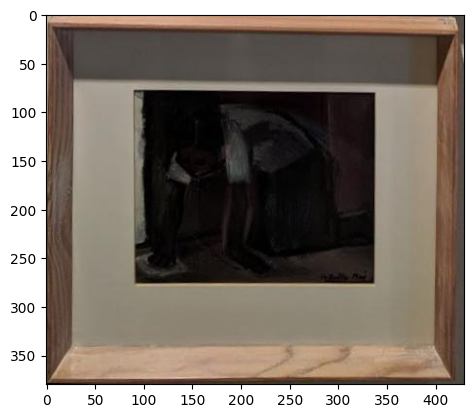

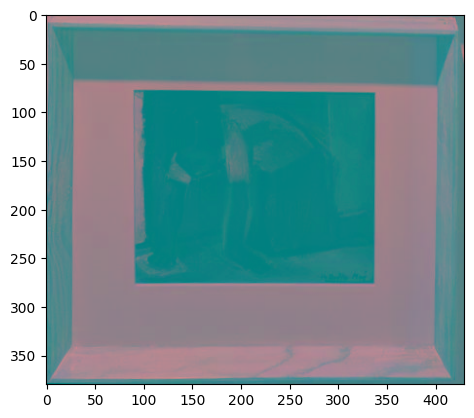

In [7]:
# Plot descriptor (histogram of each color channel) for the first image of the Query dataset. Colorspace: HSV & bin interval size=1
QueryDataset.images[0].plot_histograms()
QueryDataset.images[0].show_original()
QueryDataset.images[0].show()

## Task 2

In [5]:
"""
# TASK 2: Similarity measures

Distance:
    - Euclidean distance
    - L1 distance
    - χ2

Similarity:
    - Histogram intersection (similarity)
    - Hellinger kernel (similarity)
"""

# Implementation of the distances, similarities and evaluation metrics
from src.metrics import *

## Task 3

In [ ]:
"""
# TASK 3: For each image in QSD1, compute similarities to museum images

- Return the top k images (highest score, lowest distance)
- Evaluation with mAP@K (mean Average Precision at K)

Provide mAP@k (k=1, k=5) results for the validation query set (QSD1)
"""

In [ ]:
# Return top k results
k = 5

result = [[] for _ in range(len(QueryDataset.images))]

for image in QueryDataset.images:
    distances_list = []
    for image2 in BDDataset.images:
        distances = image.compute_distance(image2, type=DistanceType.l1)
        distance = np.mean(distances) # We can play with min, max, sum ...
        distances_list.append(distance)
    top_k = np.argsort(distances_list)[:k]

    result[image.index] = [BDDataset.images[i].index for i in top_k]

In [7]:
# Load ground truth correspondences
with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

# Compute mAP@K for k=1 and k=5
mapk(ground_truth, result, k=k)

0.46888888888888897

In [24]:
"""
Let's verify that the distance from the query image to it's correspondence on the DB is lower than a randomly selected image on the DB
"""

image1 = Image(f'{DATA_DIRECTORY}/qsd1_w1/00000.jpg', colorspace=ColorSpace.HSV) # Query (first img of the QSD1)

image1_bbdd = Image(f'{DATA_DIRECTORY}/BBDD/bbdd_00120.jpg', colorspace=ColorSpace.HSV) # BBDD (same img than image1)
rand_image_bbdd = Image(f'{DATA_DIRECTORY}/BBDD/bbdd_00229.jpg', colorspace=ColorSpace.HSV) # BBDD (random img from BBDD)


print(
f'Distance(img1, img1_bbdd): {np.mean(image1.compute_distance(image1_bbdd, type=DistanceType.l1))} \n'
f'Distance(img1, rand_img_bbdd): {np.mean(image1.compute_distance(rand_image_bbdd, type=DistanceType.l1))} \n\n'

'Distance from image1 to it\'s correspondence from BBDD is lower than to a randomly selected image in BBDD. \n'
'Things are working as expected :)'
)

Distance(img1, img1_bbdd): 0.5206865071937165 
Distance(img1, rand_img_bbdd): 0.8166156570173898 

Distance from image1 to it's correspondence from BBDD is lower than to a randomly selected image in BBDD. 
Things are working as expected :)


## Task 3.5: Find top-2 methods

In [ ]:
""" 
Before submiting the results for testing with QST1, let's find the methods that work better.
We will try to optimize mAP@K with the parameters: 
   - Colorspace of the image 
   - bin_size of the hitograms 
   - Metric to compute differences between descriptors (distance or similarity).
   - Handling of the three distances (one for each channel) before computing mAP@K: Mean, min, max, sum...
"""



## Task 4

In [ ]:
""" 
# TASK 4: Submit your results for a “blind” competition in QST1

Format: For each test query in QST1, a list of the K=10 best results:
    - Create a python list of lists, with the image ids (integer numbers)
    - Example with 3 queries and K=2
        Query: [[q1], [q2], [q3]]
        Result: [[7,2], [76, 4], [43, 12]]
    Where 7 corresponds to image 00007.jpg, etc.
"""

# For loop

In [55]:
from typing import Dict, List
import numpy as np
from src.metrics import DistanceType, SimilarityType, apk

def compute_results_by_distance(
      bdd_dataset: ImageDataset,
      query_dataset: ImageDataset,
      ground_truth: List[List[int]],
      distance_type: DistanceType = DistanceType.l1
   ) -> Dict:

   result = []
   distances_result = []
   for image in query_dataset:
      distances_list = []
      for image2 in bdd_dataset:
         distances = image.compute_distance(image2, type=distance_type)
         distance = np.mean(distances)
         distances_list.append(distance)
      top_k = np.argsort(distances_list)[:5]

      result.append([bdd_dataset[i].index for i in top_k])
      distances_result.append([distances_list[i] for i in top_k])
   
   return {
      'apk1': [apk(a,p,1) for a,p in zip(ground_truth, result)],
      'apk5': [apk(a,p,5) for a,p in zip(ground_truth, result)],
      'distances': distances_result
   }


def compute_results_by_similarity(
      bdd_dataset: ImageDataset,
      query_dataset: ImageDataset,
      ground_truth: List[List[int]],
      similarity_type: SimilarityType = SimilarityType.histogram_intersection
   ) -> Dict:

   result = []
   similarities_result = []
   for image in query_dataset:
      similarities_list = []
      for image2 in bdd_dataset:
         similarities = image.compute_similarity(image2, type=similarity_type)
         similarity = np.mean(similarities)
         similarities_list.append(similarity)
      top_k = np.argsort(similarities_list)[-5:][::-1]

      result.append([bdd_dataset[i].index for i in top_k])
      similarities_result.append([similarities_list[i] for i in top_k])
   
   return {
      'apk1': [apk(a,p,1) for a,p in zip(ground_truth, result)],
      'apk5': [apk(a,p,5) for a,p in zip(ground_truth, result)],
      'similarities': similarities_result
   }

In [21]:
import numpy as np

BBDD_PATH = f'{DATA_DIRECTORY}/BBDD'
QUERY_PATH = f'{DATA_DIRECTORY}/qsd1_w1'

# Load ground truth correspondences
with open(f'{QUERY_PATH}/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

### Test with different colorspaces

In [22]:
result_colorspaces = {}

# Check for each colorspace which ones works better
for colorspace in ColorSpace:
   print('Processing for colorspace:', colorspace.name)
   bdd_dataset = ImageDataset(BBDD_PATH, colorspace=colorspace)
   query_dataset = ImageDataset(QUERY_PATH, colorspace=colorspace)

   result_colorspaces[colorspace.name] = compute_results_by_distance(
       bdd_dataset, query_dataset, ground_truth, DistanceType.l1,
    )

Processing for colorspace: gray
Processing for colorspace: RGB
Processing for colorspace: HSV
Processing for colorspace: CieLab
Processing for colorspace: YCbCr


In [23]:
for colorspace, result in result_colorspaces.items():
    print('Colorspace:', colorspace)
    print('-------------------------')
    print(' -> MAPK1 =', np.mean(result['apk1']))
    print(' -> MAPK5 =', np.mean(result['apk5']))
    

Colorspace: gray
-------------------------
 -> MAPK1 = 0.26666666666666666
 -> MAPK5 = 0.2833333333333333
Colorspace: RGB
-------------------------
 -> MAPK1 = 0.3333333333333333
 -> MAPK5 = 0.3722222222222223
Colorspace: HSV
-------------------------
 -> MAPK1 = 0.36666666666666664
 -> MAPK5 = 0.46888888888888897
Colorspace: CieLab
-------------------------
 -> MAPK1 = 0.43333333333333335
 -> MAPK5 = 0.525
Colorspace: YCbCr
-------------------------
 -> MAPK1 = 0.3333333333333333
 -> MAPK5 = 0.42888888888888893


### Test with different intervals

In [42]:
result_intervals = {}

intervals = [i+1 for i in range(20)]

# Check for colorspace CieLab with and different intervals
for interval in intervals:
   print('Processing for interval:', interval)
   bdd_dataset = ImageDataset(BBDD_PATH, colorspace=ColorSpace.CieLab, interval=interval)
   query_dataset = ImageDataset(QUERY_PATH, colorspace=ColorSpace.CieLab, interval=interval)

   result_intervals[interval] = compute_results_by_distance(
       bdd_dataset, query_dataset, ground_truth, DistanceType.l1,
    )

Processing for interval: 1
Processing for interval: 2
Processing for interval: 3
Processing for interval: 4
Processing for interval: 5
Processing for interval: 6
Processing for interval: 7
Processing for interval: 8
Processing for interval: 9
Processing for interval: 10
Processing for interval: 11
Processing for interval: 12
Processing for interval: 13
Processing for interval: 14
Processing for interval: 15
Processing for interval: 16
Processing for interval: 17
Processing for interval: 18
Processing for interval: 19
Processing for interval: 20


In [43]:
for interval, result in result_intervals.items():
    print('Interval:', interval)
    print('-------------------------')
    print(' -> MAPK1 =', np.mean(result['apk1']))
    print(' -> MAPK5 =', np.mean(result['apk5']))

Interval: 1
-------------------------
 -> MAPK1 = 0.43333333333333335
 -> MAPK5 = 0.525
Interval: 2
-------------------------
 -> MAPK1 = 0.43333333333333335
 -> MAPK5 = 0.5288888888888889
Interval: 3
-------------------------
 -> MAPK1 = 0.4666666666666667
 -> MAPK5 = 0.5555555555555555
Interval: 4
-------------------------
 -> MAPK1 = 0.5333333333333333
 -> MAPK5 = 0.5994444444444444
Interval: 5
-------------------------
 -> MAPK1 = 0.5
 -> MAPK5 = 0.5833333333333334
Interval: 6
-------------------------
 -> MAPK1 = 0.43333333333333335
 -> MAPK5 = 0.5522222222222222
Interval: 7
-------------------------
 -> MAPK1 = 0.5333333333333333
 -> MAPK5 = 0.615
Interval: 8
-------------------------
 -> MAPK1 = 0.5
 -> MAPK5 = 0.586111111111111
Interval: 9
-------------------------
 -> MAPK1 = 0.5333333333333333
 -> MAPK5 = 0.6055555555555556
Interval: 10
-------------------------
 -> MAPK1 = 0.5333333333333333
 -> MAPK5 = 0.5816666666666667
Interval: 11
-------------------------
 -> MAPK1 = 0.

### Check Distances

In [47]:
result_distances = {}

for distance in [DistanceType.l1, DistanceType.euclidean, DistanceType.chi2]:
   print('Processing for distance:', distance.__name__)
   bdd_dataset = ImageDataset(BBDD_PATH, colorspace=ColorSpace.CieLab, interval=14)
   query_dataset = ImageDataset(QUERY_PATH, colorspace=ColorSpace.CieLab, interval=14)
   result_distances[distance.__name__] = compute_results_by_distance(
       bdd_dataset, query_dataset, ground_truth, distance,
    )


Processing for distance: l1_distance
Processing for distance: euclidean_distance
Processing for distance: chi2_distance


In [48]:
for distance, result in result_distances.items():
    print('Distance:', distance)
    print('-------------------------')
    print(' -> MAPK1 =', np.mean(result['apk1']))
    print(' -> MAPK5 =', np.mean(result['apk5']))

Distance: l1_distance
-------------------------
 -> MAPK1 = 0.5666666666666667
 -> MAPK5 = 0.6288888888888889
Distance: euclidean_distance
-------------------------
 -> MAPK1 = 0.5333333333333333
 -> MAPK5 = 0.5844444444444445
Distance: chi2_distance
-------------------------
 -> MAPK1 = 0.4666666666666667
 -> MAPK5 = 0.5444444444444445


### Check Similarities

In [57]:
result_similarities = {}

# Check for each colorspace which ones works better
for similarity in [SimilarityType.histogram_intersection, SimilarityType.hellinger_kernel]:
   print('Processing for similarity:', similarity.__name__)
   bdd_dataset = ImageDataset(BBDD_PATH, colorspace=ColorSpace.CieLab, interval=14)
   query_dataset = ImageDataset(QUERY_PATH, colorspace=ColorSpace.CieLab, interval=14)

   result_similarities[similarity.__name__] = compute_results_by_similarity(
       bdd_dataset, query_dataset, ground_truth, similarity,
    )

Processing for similarity: histogram_intersection_similarity
Processing for similarity: hellinger_kernel_similarity


In [58]:
for similarity, result in result_similarities.items():
    print('Similarity:', similarity)
    print('-------------------------')
    print(' -> MAPK1 =', np.mean(result['apk1']))
    print(' -> MAPK5 =', np.mean(result['apk5']))

Similarity: histogram_intersection_similarity
-------------------------
 -> MAPK1 = 0.5666666666666667
 -> MAPK5 = 0.6288888888888889
Similarity: hellinger_kernel_similarity
-------------------------
 -> MAPK1 = 0.5
 -> MAPK5 = 0.5611111111111112
